## Loading Data & Libraries

In [1544]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.linear_model import HuberRegressor, LinearRegression
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)
#pd.set_option('display.width', 1000)
df_train = pd.read_csv("train.csv",index_col=0)
df_test = pd.read_csv("test.csv",index_col=0)
y = df_train["failure"]
df = df_train.drop("failure",axis=1)
df = pd.concat([df,df_test])
#26570
df.head()

ImportError: cannot import name '_ClassNamePrefixFeaturesOutMixin' from 'sklearn.base' (/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py)

## Data Discovery

In [1507]:
df_train.iloc[:,9:]

,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,
0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,16.301,13.259,18.068,15.505,10.865,19.354,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0
26566,17.543,NaN,17.984,19.078,11.139,19.563,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0
26567,15.670,11.535,16.778,18.385,11.630,19.279,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0


### Corelation

A


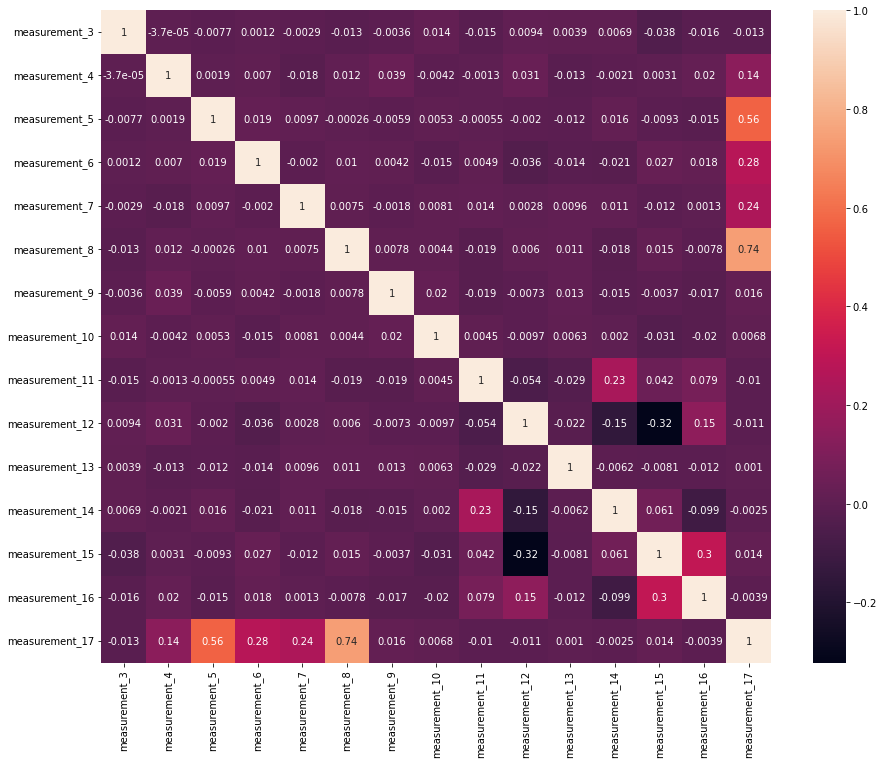

B


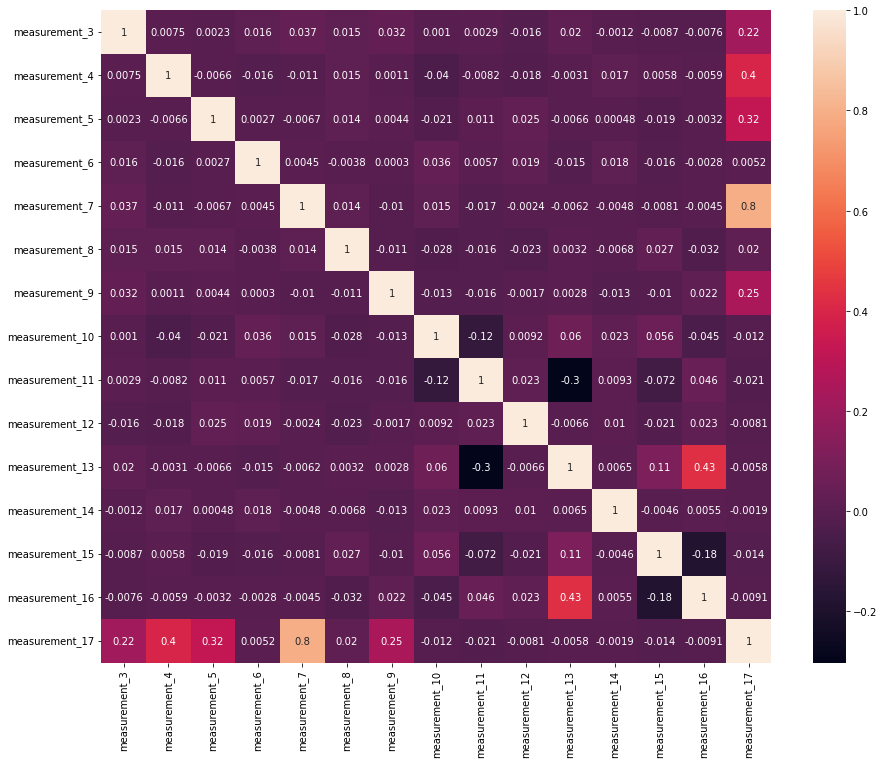

C


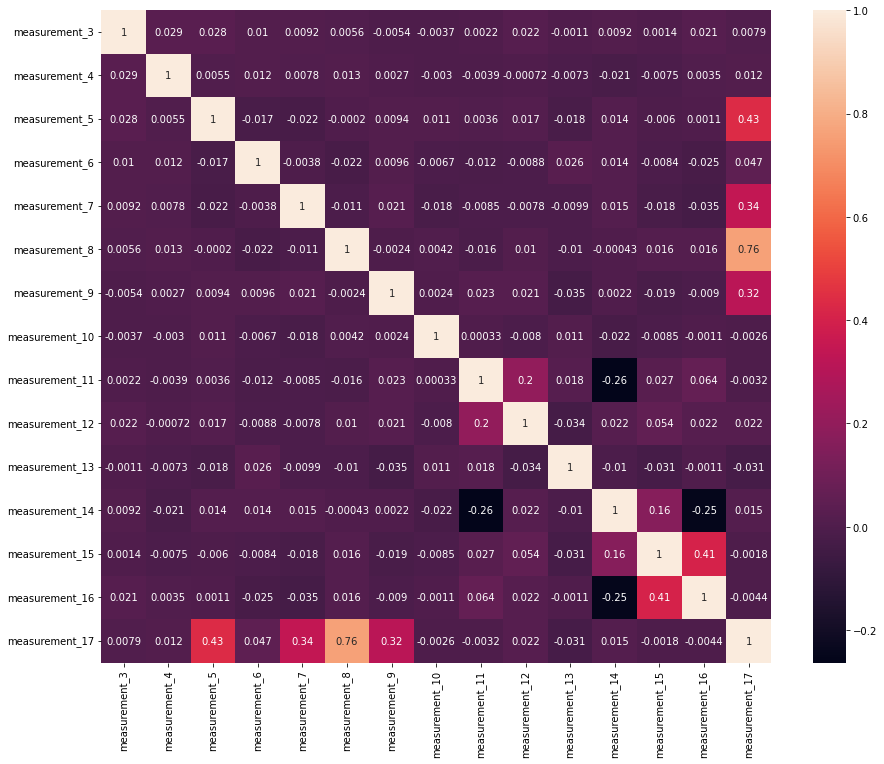

D


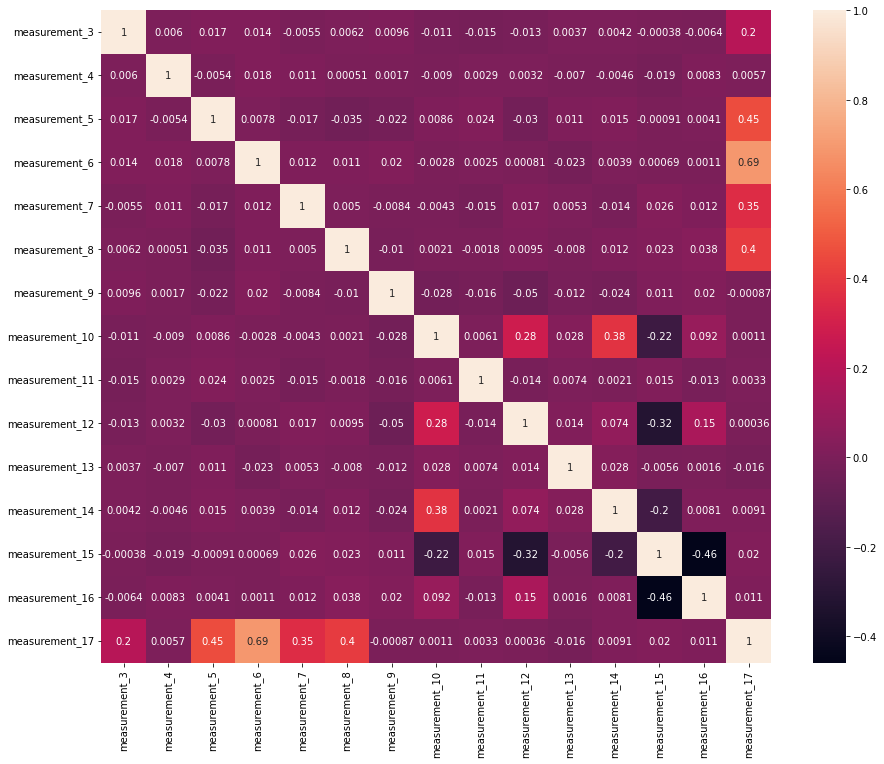

E


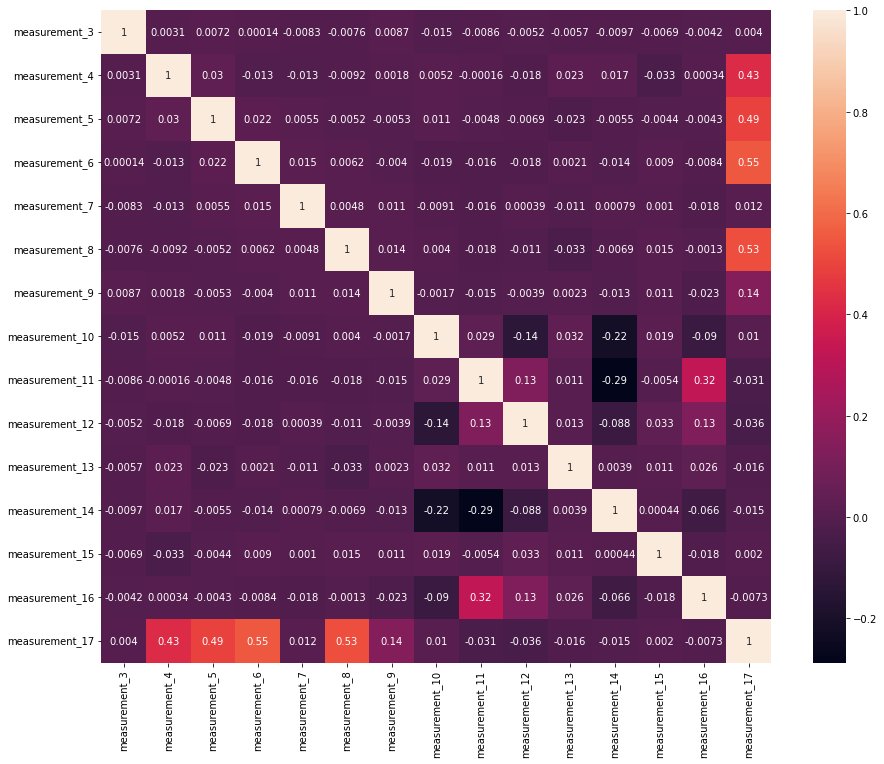

F


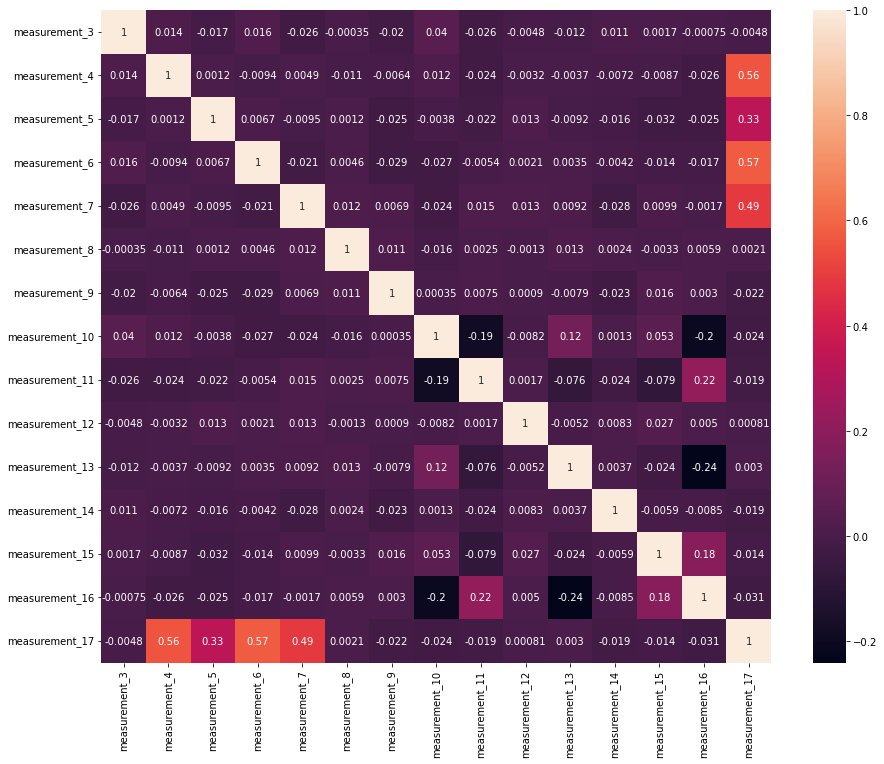

G


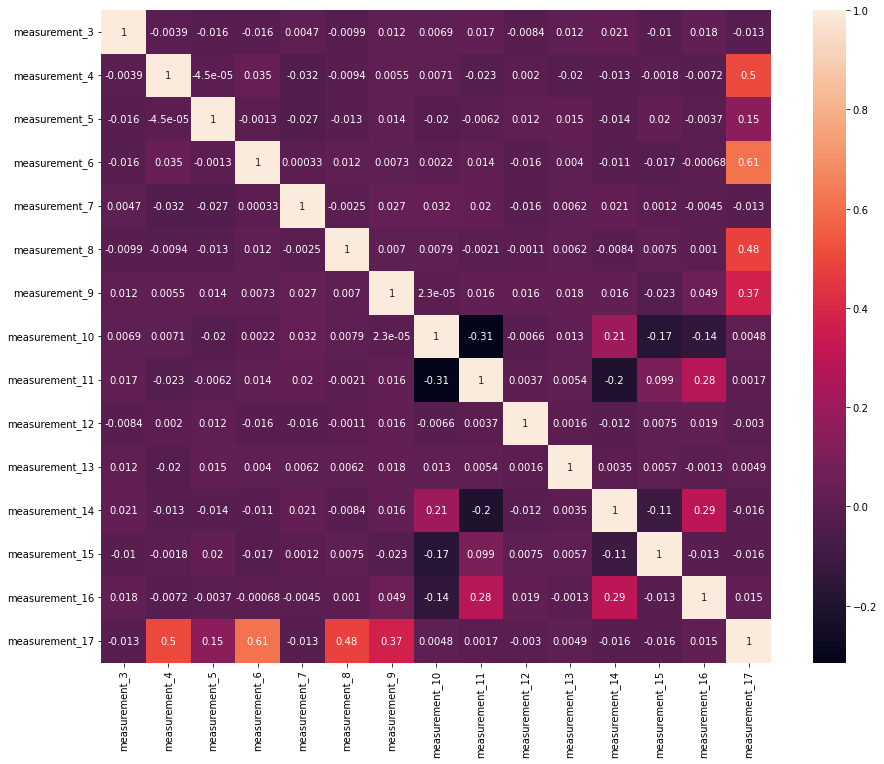

H


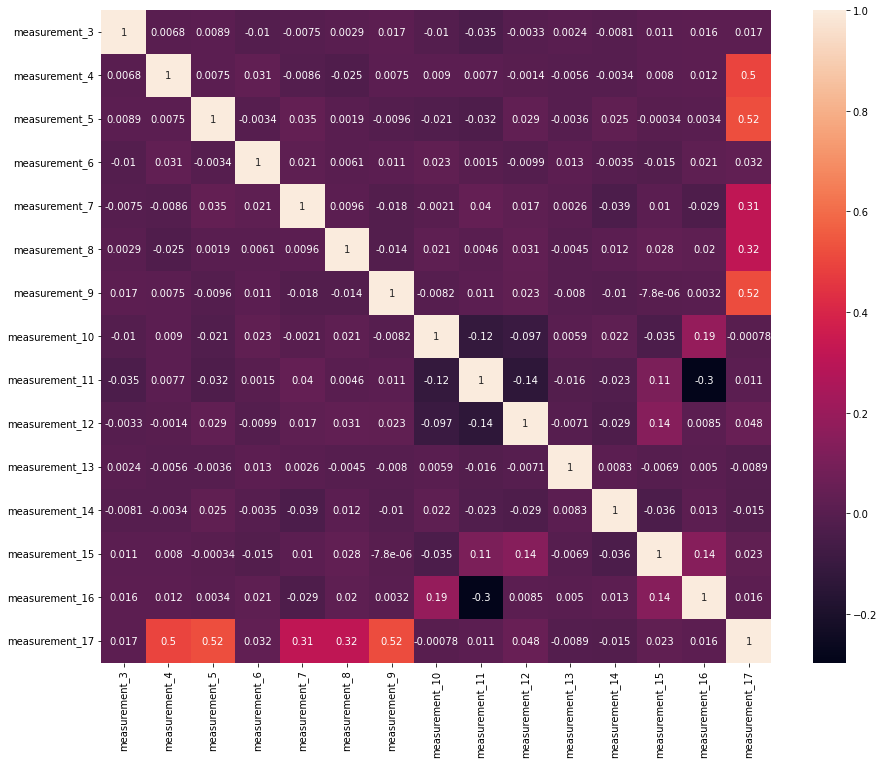

I


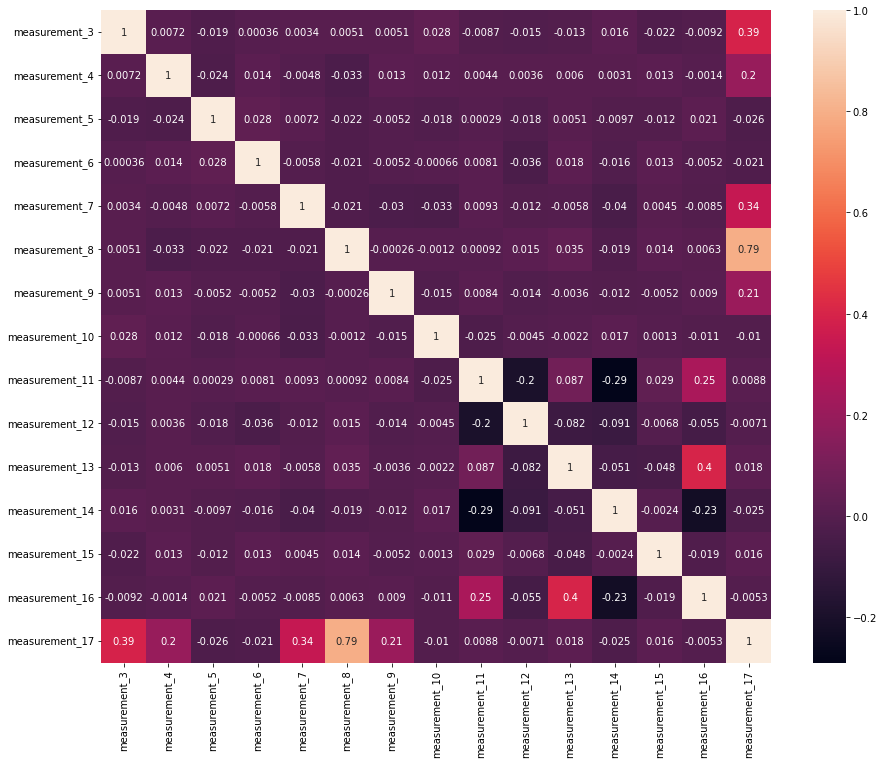

In [1509]:
for i in df["product_code"].unique():
    print(i)
    plt.figure(figsize=(15,12))
    sns.heatmap(df[df["product_code"]==i].iloc[:,9:].corr(),annot=True)
    plt.show()

## Imputation

In [1510]:
correlation ={
"A":["measurement_5","measurement_6","measurement_7","measurement_8","measurement_17"],
"B":["measurement_4","measurement_5","measurement_7","measurement_9","measurement_17"],
"C":["measurement_5","measurement_7","measurement_8","measurement_9","measurement_17"],
"D":["measurement_5","measurement_6","measurement_7","measurement_8","measurement_17"],
"E":["measurement_4","measurement_5","measurement_6","measurement_8","measurement_17"],
"F":["measurement_4","measurement_5","measurement_6","measurement_7","measurement_17"],
"G":["measurement_4","measurement_5","measurement_6","measurement_7","measurement_17"],
"H":["measurement_4","measurement_6","measurement_8","measurement_9","measurement_17"],
"I":["measurement_3","measurement_7","measurement_8","measurement_17"]
}

In [1511]:
df["measurement_17"].isna().value_counts()

False    43321
True      4024
Name: measurement_17, dtype: int64

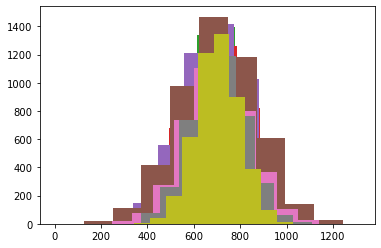

In [1512]:
for i in df["product_code"].unique():
    plt.hist(df[df["product_code"]==i]["measurement_17"])

In [1514]:
correlation["A"]
[df["product_code"]=="A"]

[id
 0         True
 1         True
 2         True
 3         True
 4         True
          ...  
 47340    False
 47341    False
 47342    False
 47343    False
 47344    False
 Name: product_code, Length: 47345, dtype: bool]

In [1515]:
i

'I'

In [1516]:
for i in df["product_code"].unique():
    temp = df[df["product_code"]==i][correlation[i]]
    tmpX = temp.dropna().iloc[:,:-1]
    tmpY = temp.dropna()["measurement_17"]
    tmpXf = temp.loc[temp.iloc[:,:-1].dropna().index][temp.loc[temp.iloc[:,:-1].dropna().index]["measurement_17"].isna()].iloc[:,:-1]
    huber = HuberRegressor()
    regressor = huber.fit(tmpX,tmpY)
    predict = regressor.predict(tmpXf)
    df.loc[tmpXf.index,"measurement_17"]=predict

    tempKNN = df[df["product_code"]==i][correlation[i]]
    ind = tempKNN.index
    imputer = KNNImputer()
    tempKNN = imputer.fit_transform(tempKNN)
    df.loc[ind,correlation[i]]=tempKNN

## Data Preprocessing

In [1517]:
cat = ["product_code","attribute_0","attribute_1"]
non_cat = [k for k in df if k not in cat]
imputer = KNNImputer()
df[non_cat] = imputer.fit_transform(df[non_cat])
df

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9.0,5.0,7.0,8.0,4.0,18.040,12.5180,15.748,19.2920,11.739,20.155,10.672,15.8590,17.5940,15.193,15.029,15.6508,13.034,14.6840,764.100
1,A,84.89,material_7,material_8,9.0,5.0,14.0,3.0,3.0,18.213,11.5400,17.717,17.8930,12.748,17.889,12.448,17.9470,17.9150,11.755,14.732,15.4250,14.395,15.6310,682.057
2,A,82.43,material_7,material_8,9.0,5.0,12.0,1.0,5.0,18.057,11.6520,16.738,18.2400,12.718,18.288,12.715,15.6070,18.4742,13.798,16.711,18.6310,14.094,17.9460,663.376
3,A,101.07,material_7,material_8,9.0,5.0,13.0,2.0,6.0,17.295,11.1880,18.576,18.3390,12.583,19.060,12.471,16.3460,18.3770,10.020,15.250,15.5620,16.154,17.1720,826.282
4,A,188.06,material_7,material_8,9.0,5.0,9.0,2.0,8.0,19.346,12.9500,16.990,15.7460,11.306,18.093,10.337,17.0820,19.9320,12.428,16.182,12.7600,13.153,16.4120,579.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,I,144.74,material_7,material_5,9.0,5.0,0.0,4.0,9.0,18.465,12.5700,18.146,17.0890,11.204,18.573,11.691,15.4022,19.7710,11.562,17.246,15.1310,15.209,16.4334,696.466
47341,I,74.53,material_7,material_5,9.0,5.0,4.0,8.0,7.0,18.900,9.8960,18.288,16.4802,11.747,17.917,10.980,16.0270,15.6940,13.564,15.494,15.2960,13.812,16.5010,613.249
47342,I,67.73,material_7,material_5,9.0,5.0,10.0,11.0,2.0,18.656,11.5992,18.242,17.9100,12.081,19.630,10.436,16.1370,20.6120,11.134,16.519,15.5250,14.175,17.7280,783.349


In [1518]:
#df['m_3_missing'] = df.measurement_3.isna()
#df['m_4_missing'] = df.measurement_4.isna()
df['area'] = df['attribute_2']*df['attribute_3']
df['measurement_2'] = np.log1p(df['measurement_2'])
df['measurement_0'] = np.log1p(df['measurement_0'])
df['mean_mean35681011'] = df[['measurement_3','measurement_5','measurement_6','measurement_8','measurement_10','measurement_11','measurement_13','measurement_14','measurement_15','measurement_16']].mean(axis=1)
df['mean_std35681011'] = df[['measurement_3','measurement_5','measurement_6','measurement_8','measurement_10','measurement_11','measurement_13','measurement_14','measurement_15','measurement_16']].std(axis=1)
df['mean_mean49912'] = df[['measurement_4','measurement_7','measurement_9','measurement_12']].mean(axis=1)
df['mean_std47912'] = df[['measurement_4','measurement_7','measurement_9','measurement_12']].std(axis=1)
df["product_code"] = df["product_code"].astype("category")
df["attribute_0"] = df["attribute_0"].astype("category")
df["attribute_1"] = df["attribute_1"].astype("category")
df["loading"] = np.log1p(df["loading"])
df


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,area,mean_mean35681011,mean_std35681011,mean_mean49912,mean_std47912
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,4.395683,material_7,material_8,9.0,5.0,2.079442,8.0,1.609438,18.040,12.5180,15.748,19.2920,11.739,20.155,10.672,15.8590,17.5940,15.193,15.029,15.6508,13.034,14.6840,764.100,45.0,16.50858,2.208427,12.53050,1.929556
1,A,4.453067,material_7,material_8,9.0,5.0,2.708050,3.0,1.386294,18.213,11.5400,17.717,17.8930,12.748,17.889,12.448,17.9470,17.9150,11.755,14.732,15.4250,14.395,15.6310,682.057,45.0,16.77570,1.530751,12.12275,0.569082
2,A,4.424008,material_7,material_8,9.0,5.0,2.564949,1.0,1.791759,18.057,11.6520,16.738,18.2400,12.718,18.288,12.715,15.6070,18.4742,13.798,16.711,18.6310,14.094,17.9460,663.376,45.0,17.27862,1.483363,12.72075,0.876115
3,A,4.625659,material_7,material_8,9.0,5.0,2.639057,2.0,1.945910,17.295,11.1880,18.576,18.3390,12.583,19.060,12.471,16.3460,18.3770,10.020,15.250,15.5620,16.154,17.1720,826.282,45.0,17.21310,1.347949,11.56550,1.209175
4,A,5.242064,material_7,material_8,9.0,5.0,2.302585,2.0,2.197225,19.346,12.9500,16.990,15.7460,11.306,18.093,10.337,17.0820,19.9320,12.428,16.182,12.7600,13.153,16.4120,579.885,45.0,16.56960,2.328895,11.75525,1.168087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,I,4.981824,material_7,material_5,9.0,5.0,0.000000,4.0,2.302585,18.465,12.5700,18.146,17.0890,11.204,18.573,11.691,15.4022,19.7710,11.562,17.246,15.1310,15.209,16.4334,696.466,45.0,17.14656,1.600028,11.75675,0.579988
47341,I,4.324530,material_7,material_5,9.0,5.0,1.609438,8.0,2.079442,18.900,9.8960,18.288,16.4802,11.747,17.917,10.980,16.0270,15.6940,13.564,15.494,15.2960,13.812,16.5010,613.249,45.0,16.44092,1.545268,11.54675,1.544407
47342,I,4.230186,material_7,material_5,9.0,5.0,2.397895,11.0,1.098612,18.656,11.5992,18.242,17.9100,12.081,19.630,10.436,16.1370,20.6120,11.134,16.519,15.5250,14.175,17.7280,783.349,45.0,17.51340,1.946593,11.31255,0.700691


In [1519]:
#df = df[["loading","area","measurement_17","measurement_2","failure","mean_mean35681011","mean_mean49912"]]
df = df[["loading","measurement_17","area","measurement_0","measurement_2",
         "mean_mean35681011","mean_mean49912",
        'mean_std35681011','mean_std47912']]

In [1520]:
#df = pd.get_dummies(df)

In [1521]:
#y = df["failure"]
#df = df.drop("failure",axis=1)

In [1522]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#scalar = sc.fit(df)
#df = scalar.transform(df)

In [1523]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=6)
#df = pca.fit_transform(df)

In [1524]:
X_val = df.iloc[26570:,:]
df = df.iloc[:26570,:]
X_val.shape

(20775, 9)

In [1525]:
df.shape, y.shape

((26570, 9), (26570,))

In [1526]:
X_train, X_test, y_train, y_test = train_test_split(df,y,test_size=0.2, random_state=42)

In [1527]:
X_train.isna().any()

loading              False
measurement_17       False
area                 False
measurement_0        False
measurement_2        False
mean_mean35681011    False
mean_mean49912       False
mean_std35681011     False
mean_std47912        False
dtype: bool

### Logistic Regression

In [1528]:
#logistic Regression

#p_grid ={"penalty":['l2'],
#        "solver":["liblinear"]}
log = LogisticRegression(
                         #dual=True,
                         #solver="liblinear",
                         #class_weight="balanced",
                         max_iter=1000,
                         C=0.2)
log_cv_results = GridSearchCV(log,param_grid=p_grid, cv=4)


model_log = log.fit(X_train,y_train)
model_log.score(X_test,y_test)
#nested_scores_log = cross_val_score(estimator = cv_results,X =X,y=y,cv=4)
#log = LogisticRegression()
#model = cv_results.fit(**best_iteration_,X,y)
#y_log_prob = model.predict_proba(X)
#y_log = model.predict(X)

0.801091456529921

In [1529]:
confusion_matrix(y_test, model_log.predict(X_test))

array([[4257,    0],
       [1057,    0]])

### GaussianBN

In [1530]:
#GaussianNB
p_grid ={}

GNB = GaussianNB()
GNB_cv_results = GridSearchCV(GNB,param_grid=p_grid, cv=4)
modelGNB = GNB_cv_results.fit(X_train,y_train)
#nested_scores_GNB = cross_val_score(estimator = cv_results,X =X,y=y,cv=4)
modelGNB.score(X_test,y_test)

0.8012796386902522

In [1531]:
confusion_matrix(y_test, modelGNB.predict(X_test))

array([[4257,    0],
       [1056,    1]])

### LBGM

In [1532]:
#lgbm

#p_grid={"max_depth":[2,3],
#       "n_estimators":[20,50,100,200],
#       "min_child_samples":[3,4,5]}
lgb = LGBMClassifier(metric='auc',
                     n_estimators=8000,
                     early_stopping=800,
                     learning_rate = 0.004,
                     #class_weight = "balanced",
                     #subsample=0.2,
                     #min_split_gain=0.3,
                     max_depth=2,
                     min_child_samples=100,
                     num_leaves=6,
                     #reg_alpha=0.1,
                     #reg_lambda=0.1,
                     #colsample_bytree=0.7
                    )
#cv_results = GridSearchCV(lgb,param_grid=p_grid, cv=4)
#nested_scores_lgb = cross_val_score(estimator = cv_results,X =X,y=y,cv=4)

model_lgb = lgb.fit(X_train,y_train,
                    eval_set=[(X_train,y_train),(X_test,y_test)],
                    verbose=300)
model_lgb.score(X_test,y_test)
#y_lgb_prob = model_lgb.predict_proba(X)
#y_lgb_prob
#y_lgb = model_lgb.predict(X)

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=800, early_stopping=800 will be ignored. Current value: early_stopping_round=800
Training until validation scores don't improve for 800 rounds
[300]	training's auc: 0.593565	valid_1's auc: 0.589805
[600]	training's auc: 0.596957	valid_1's auc: 0.590632
[900]	training's auc: 0.599709	valid_1's auc: 0.591998
[1200]	training's auc: 0.602238	valid_1's auc: 0.591964
[1500]	training's auc: 0.60491	valid_1's auc: 0.592402
[1800]	training's auc: 0.60717	valid_1's auc: 0.593054
[2100]	training's auc: 0.609116	valid_1's auc: 0.593276
[2400]	training's auc: 0.610962	valid_1's auc: 0.592925
[2700]	training's auc: 0.612883	valid_1's auc: 0.59254
Early stopping, best iteration is:
[2098]	training's auc: 0.609097	valid_1's auc: 0.593281


0.801091456529921

In [1533]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, model_lgb.predict(X_test))

array([[4257,    0],
       [1057,    0]])

In [1534]:
model_lgb.feature_importances_

array([1948,  955,  196,  214,  585,  587,  601,  632,  396], dtype=int32)

## Ensemble

In [1535]:
from sklearn.metrics import confusion_matrix
final = (modelGNB.predict_proba(X_val)+model_lgb.predict_proba(X_val)+model_log.predict_proba(X_val))/3

In [1536]:
model_log.predict_proba(X_val)

array([[0.78878029, 0.21121971],
       [0.82198798, 0.17801202],
       [0.77670574, 0.22329426],
       ...,
       [0.87112495, 0.12887505],
       [0.76209693, 0.23790307],
       [0.83467376, 0.16532624]])

In [1537]:
modelGNB.predict_proba(X_val)

array([[0.79919093, 0.20080907],
       [0.83087441, 0.16912559],
       [0.81200505, 0.18799495],
       ...,
       [0.85893947, 0.14106053],
       [0.76037803, 0.23962197],
       [0.85199945, 0.14800055]])

In [1538]:
model_lgb.predict_proba(X_val)

array([[0.8088677 , 0.1911323 ],
       [0.81142326, 0.18857674],
       [0.8149071 , 0.1850929 ],
       ...,
       [0.83798851, 0.16201149],
       [0.79184844, 0.20815156],
       [0.85914892, 0.14085108]])

## Summision

In [1539]:
pd.DataFrame(final).to_csv("summision.csv")